The ThinkBayes2 framework
-------------------------

Allen Downey

This notebook describes the ThinkBayes2 module, which I wrote to demonstrate a simple approach to Bayesian statistics.  The [documentation for the module is here](http://www.greenteapress.com/thinkbayes/thinkbayes2.html).

My book, [Think Bayes](http://thinkbayes.com), is based on the previous version of this module, thinkbayes.py.  There are only a few changes changes that are not backward-compatible, so if the read the book, you can use this module.

thinkbayes2.py and supporting code are in [this GitHub repository](https://github.com/AllenDowney/ThinkBayes2).

### Introduction

thinkbayes2 is a Python module that provides a framework for Bayesian statistics.  The most important class is `Suite`, which represents a set of hypotheses that are mutually exclusive and collectively exhaustive; in other words, exactly one of the hypotheses is true.  `Suite` provides a method, `Update`, that performs a Bayesian update.

`Suite` is based on `Pmf`, which represents a probability mass function.  A Pmf is a map from possible values to their probabilities.  `Pmf` is implemented using a Python dictionary, so the values can be any hashable type.  The probabilities are normally floating-point.

This UML diagram shows the relationships among these classes:

![UML class diagram](thinkbayes2_yuml.png)

`Suite` provides `Update`, which performs a Bayesian update.  It calls `Likelihood`, which is provided by a child class, `Coin` in this example.  It also uses `Normalize`, which is provided by `Pmf`.

To use this framework, you normally define a new class that inherits from `Suite`, then provide `Likelihood`.

### Example

Suppose you are given a strange new coin and you notice that it is unbalanced.  When spun on edge, it seems to land with the "heads" side up more often than the "tails" side.  You might want to estimate the probability of landing "heads" up, which I'll call $x$.


In [3]:
from __future__ import print_function, division
import thinkbayes


class Coin(thinkbayes.Suite):
    
    def Likelihood(self, data, hypo):
        x = hypo / 100
        if data == 'H':
            return x
        else:
            return 1-x

I'm importing `print_function` and `division` so this code should be compatible with Python 2 and Python 3.

The `Likelihood` function computes the likelihood of the data under a given hypothesis.  In this example, `data` is a string, either `"H"` or `"T"`; `hypo` is the hypothetical value of $x$ in the range 0 to 100.

The next step is to instantiate a Coin suite that represents the prior distribution of $x$.  To start simple, I'll use a uniform distribution on the integers from 0 to 100:

In [4]:
suite = Coin(range(0, 101))

`thinkplot` is a module that comes with ThinkBayes2.  It provides wrappers for some of the functions in Matplotlib, and includes functions like `Pdf` that known how to plot `Suites` and other objects from ThinkBayes2.

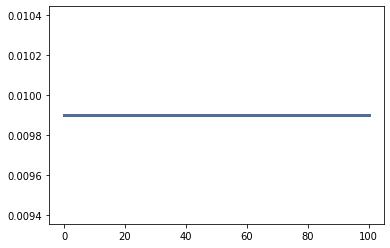

In [6]:
from thinkbayes import thinkplot
thinkplot.Pdf(suite)

As expected, the prior is uniform.

The next step is to update the prior with data.  Since Update modifies the Suite, I'll make a copy before updating.

In [7]:
posterior = suite.Copy()
posterior.Update('H')

0.5000000000000003

The return value from Update is the normalizing constant, which is the average likelihood of the data across all hypotheses.

After the update, large values of $x$ are more likely than small ones, and the hypothesis that $x=0$ has been eliminated.

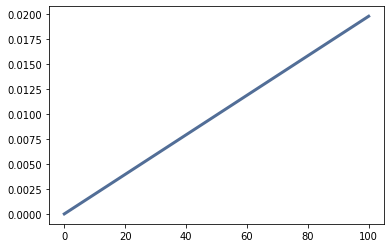

In [8]:
thinkplot.Pdf(posterior)

With additional data we can do a sequence of updates.  The result shows the cumulative effect of all updates.

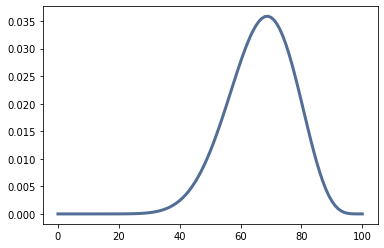

In [9]:
results = 'HTHHTHHHTTHHHTH'
for data in results:
    posterior.Update(data)
    
thinkplot.Pdf(posterior)

This distribution shows what what we should believe about $x$ after seeing this data (based on the assumption of a uniform prior).

### Implementation

ThinkBayes2 is a very simple library.  The `Pmf` class is basically a wrapper for a Python dictionary.  The only substantive method in it is `Normalize`:

In [10]:
class Pmf(object):

    def Normalize(self, fraction=1.0):
        """Normalizes this PMF so the sum of all probs is fraction.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        if self.log:
            raise ValueError("Normalize: Pmf is under a log transform")

        total = self.Total()
        if total == 0.0:
            raise ValueError('Normalize: total probability is zero.')
            #logging.warning('Normalize: total probability is zero.')
            #return total

        factor = fraction / total
        for x in self.d:
            self.d[x] *= factor

        return total

And the only substantial method in `Suite` is `Update`:

In [11]:
class Suite(Pmf):
    """Represents a suite of hypotheses and their probabilities."""

    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data

        returns: the normalizing constant
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        return self.Normalize()


As far as the implementation goes, that's all there is to it.  But if you are not sure how or why it works, you should read [Chapter 3](http://www.greenteapress.com/thinkbayes/html/thinkbayes004.html) and [Chapter 4](http://www.greenteapress.com/thinkbayes/html/thinkbayes005.html) of Think Bayes.